We are going to take a look at how mixed precision or fp16 training works.

### Getting setup

In [1]:
#| echo: false
from fastai.vision.all import *
from fastxtend.utils import less_random

In [2]:
#| echo: false
path = untar_data(URLs.CIFAR)
files = get_image_files(path/"images")
def label_func(f): return f[0].isupper()

Lets start by looking at our data. We are working with low resolution cifar images.

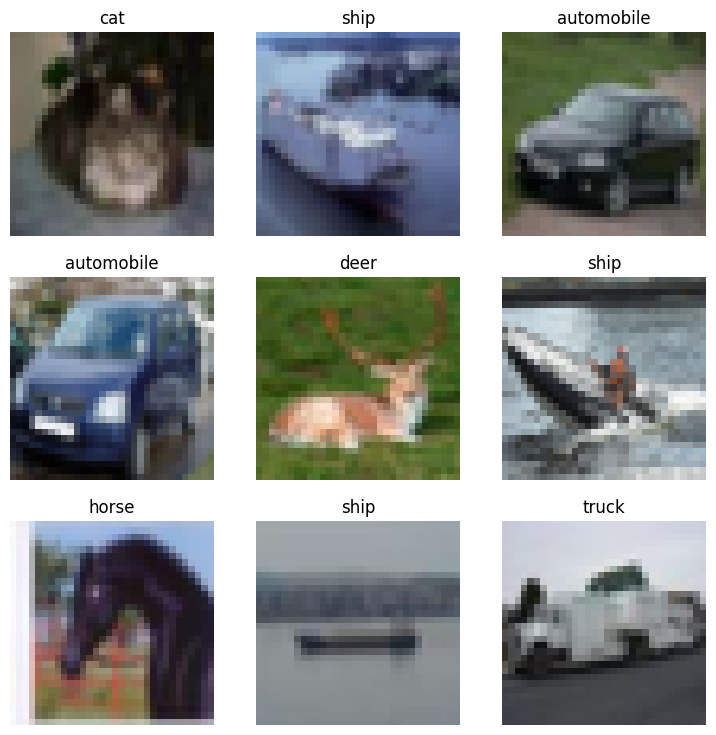

In [3]:
bs=128
dls=DataBlock((ImageBlock(),
               CategoryBlock()),
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats)),
          get_items=get_image_files,
          get_y=parent_label
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

We create a function to recreate our dataloader, because we will be doing it a lot for repeatability. 

In [4]:
def create_dls():
    bs=128
    return DataBlock((ImageBlock(),
                   CategoryBlock()),
              item_tfms=[Resize(32)],
              batch_tfms=(Normalize.from_stats(*cifar_stats)),
              get_items=get_image_files,
              get_y=parent_label
    ).dataloaders(path,bs=bs,val_bs=2*bs)

We will just use a simple resnet to test our work. 

In [5]:
learn=Learner(dls,resnet18(),opt_func=SGD)

We can make a tensor fp16 by calling `Tensor.half()`

In [6]:
torch.tensor(5.),torch.tensor(5.).half()

(tensor(5.), tensor(5., dtype=torch.float16))

### Whole model half precision

We start by training our whole model using half precision. This includes converting our input data and out parameters to fp16. 

In [7]:
class fp16Callback(Callback):
    def before_batch(self):
        self.learn.xb=(self.xb[0].half(),)
        self.learn.model=self.model.half()
    def after_batch(self):
        #fix loss for logging
        self.learn.loss=self.learn.loss.float()

In [8]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback])
    learn.fit(6)

How does this compare to training with fp32?

In [9]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD)
    learn.fit(6)

Seems we are doing a bit worse... 

### Looking at the gradients. 

We create a callback that collects the data needed to create a  colorful deminsion graph of our gradients.

In [10]:
#| echo: false
class GradLogCallback(Callback):
    def before_train(self):
        self.log={}
    def after_backward(self):
        for n,p in learn.model.named_parameters():
            if p.numel()>10: 
                if n not in self.log: self.log[n]=[]
                self.log[n]+=[p.cpu().abs().float().histc(100,0,1)]

In [11]:
@patch
def after_backward(self:GradLogCallback):
    for n,p in learn.model.named_parameters():
        if p.numel()>10: 
            if n not in self.log: self.log[n]=[]
            self.log[n]+=[p.cpu().abs().float().histc(100,0,1)]

In [12]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback,GradLogCallback])
    learn.fit(6)

In [15]:
#| echo: false
def get_hist(h): return torch.stack(h).t().float().log1p()
def show_colorful_grid(log):
    axes = get_grid(62, figsize=(12,44),ncols=2)
    for ax,k in zip(axes, learn.cbs[-1].log):
        show_image(get_hist(log[k][1:]), ax, origin='lower',title=k)

Most of the gradients are very close to zero. Just something to take note of, as the gradients don't have a standard deviation of 1 like the activations. 

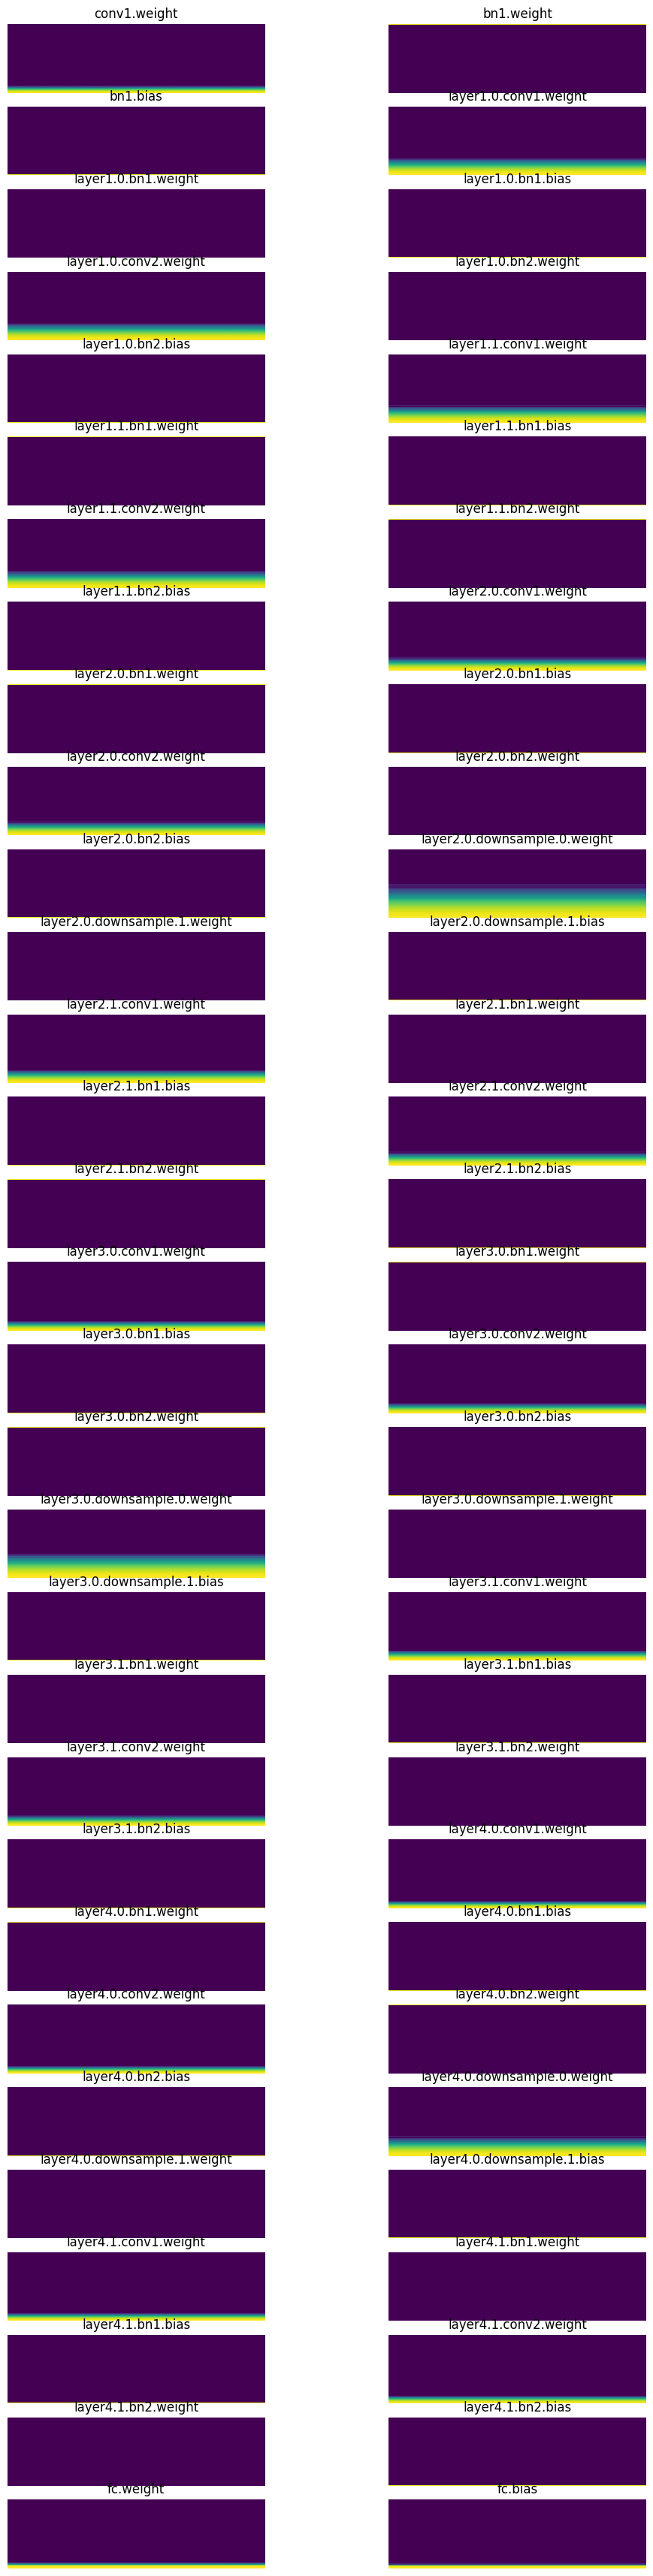

In [16]:
show_colorful_grid(learn.cbs[-1].log)

In [17]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[GradLogCallback])
    learn.fit(6)

The fp32 gradients actually look fairly similar. 

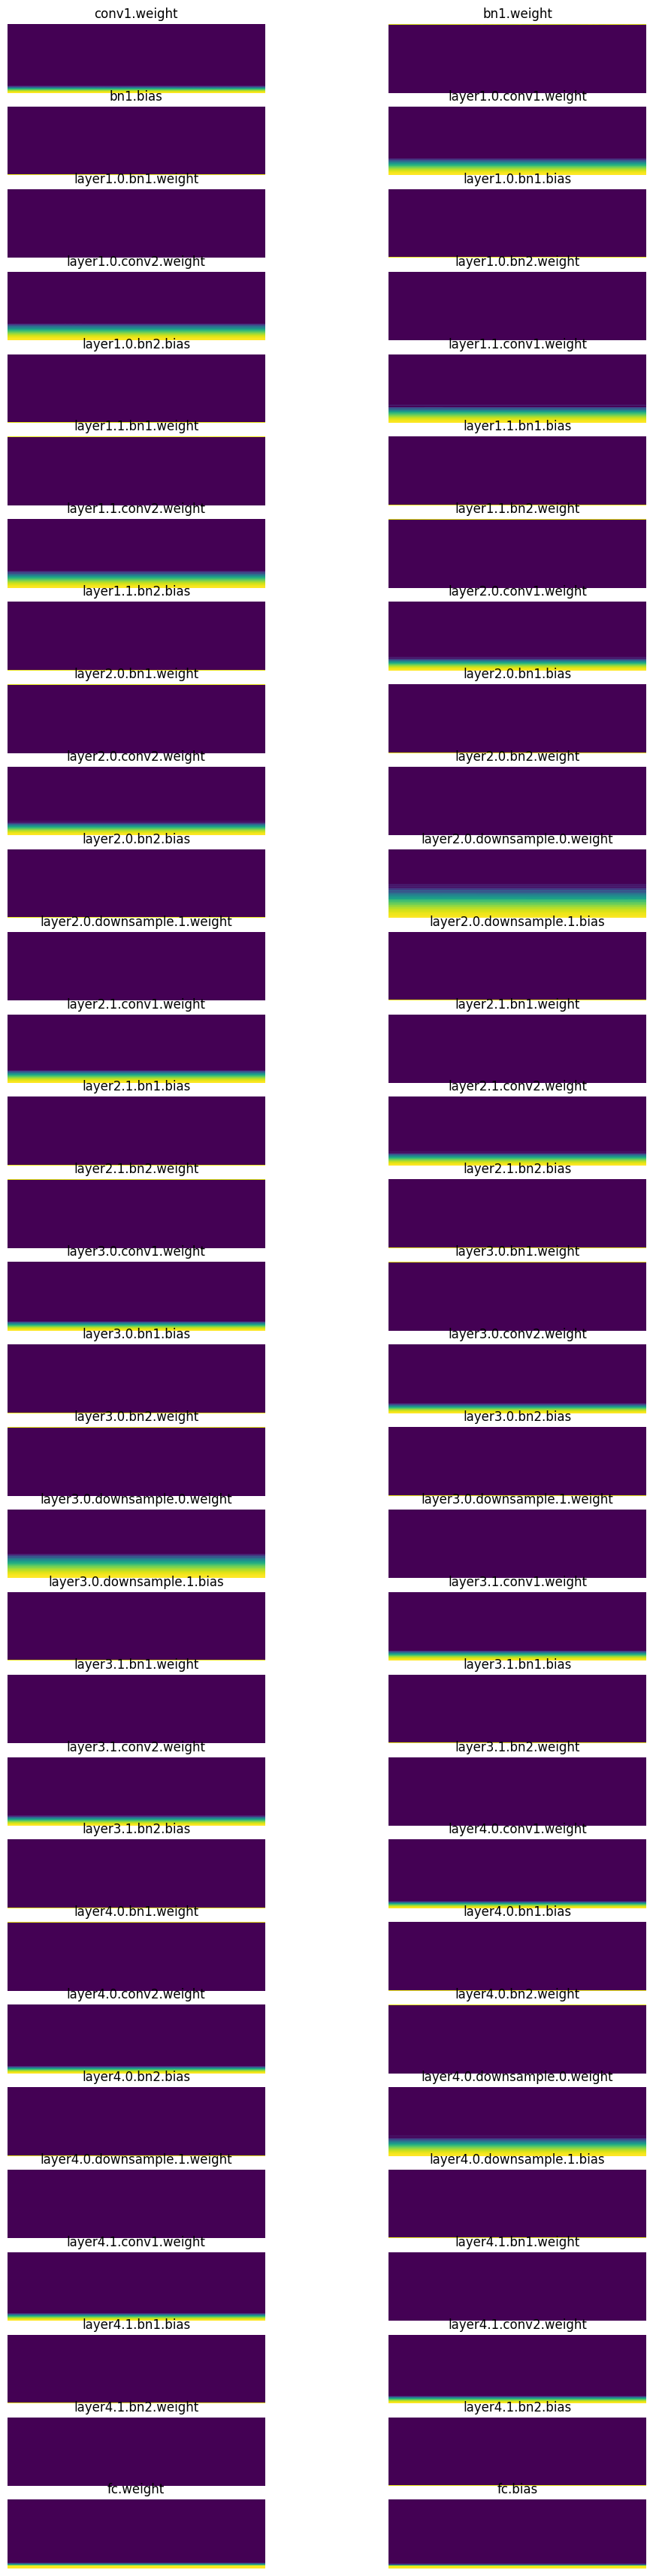

In [19]:
show_colorful_grid(learn.cbs[-1].log)

### Looking near 0 for the Gradients

We look from 0 to 3 times the standard deviation of the first batch to get a closer look at the gradients

In [20]:
@patch
def after_backward(self:GradLogCallback):
    for n,p in learn.model.named_parameters():
        if p.numel()>10: 
            if n not in self.log: self.log[n]=[3*p.cpu().abs().float().std()]
            self.log[n]+=[p.cpu().abs().float().histc(100,0,self.log[n][0].item())]

In [21]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback,GradLogCallback])
    learn.fit(6)

In [22]:
fp16_log=learn.grad_log.log

We can see something now! Pay a little bit of attention to the `bn.weight` graphs. 

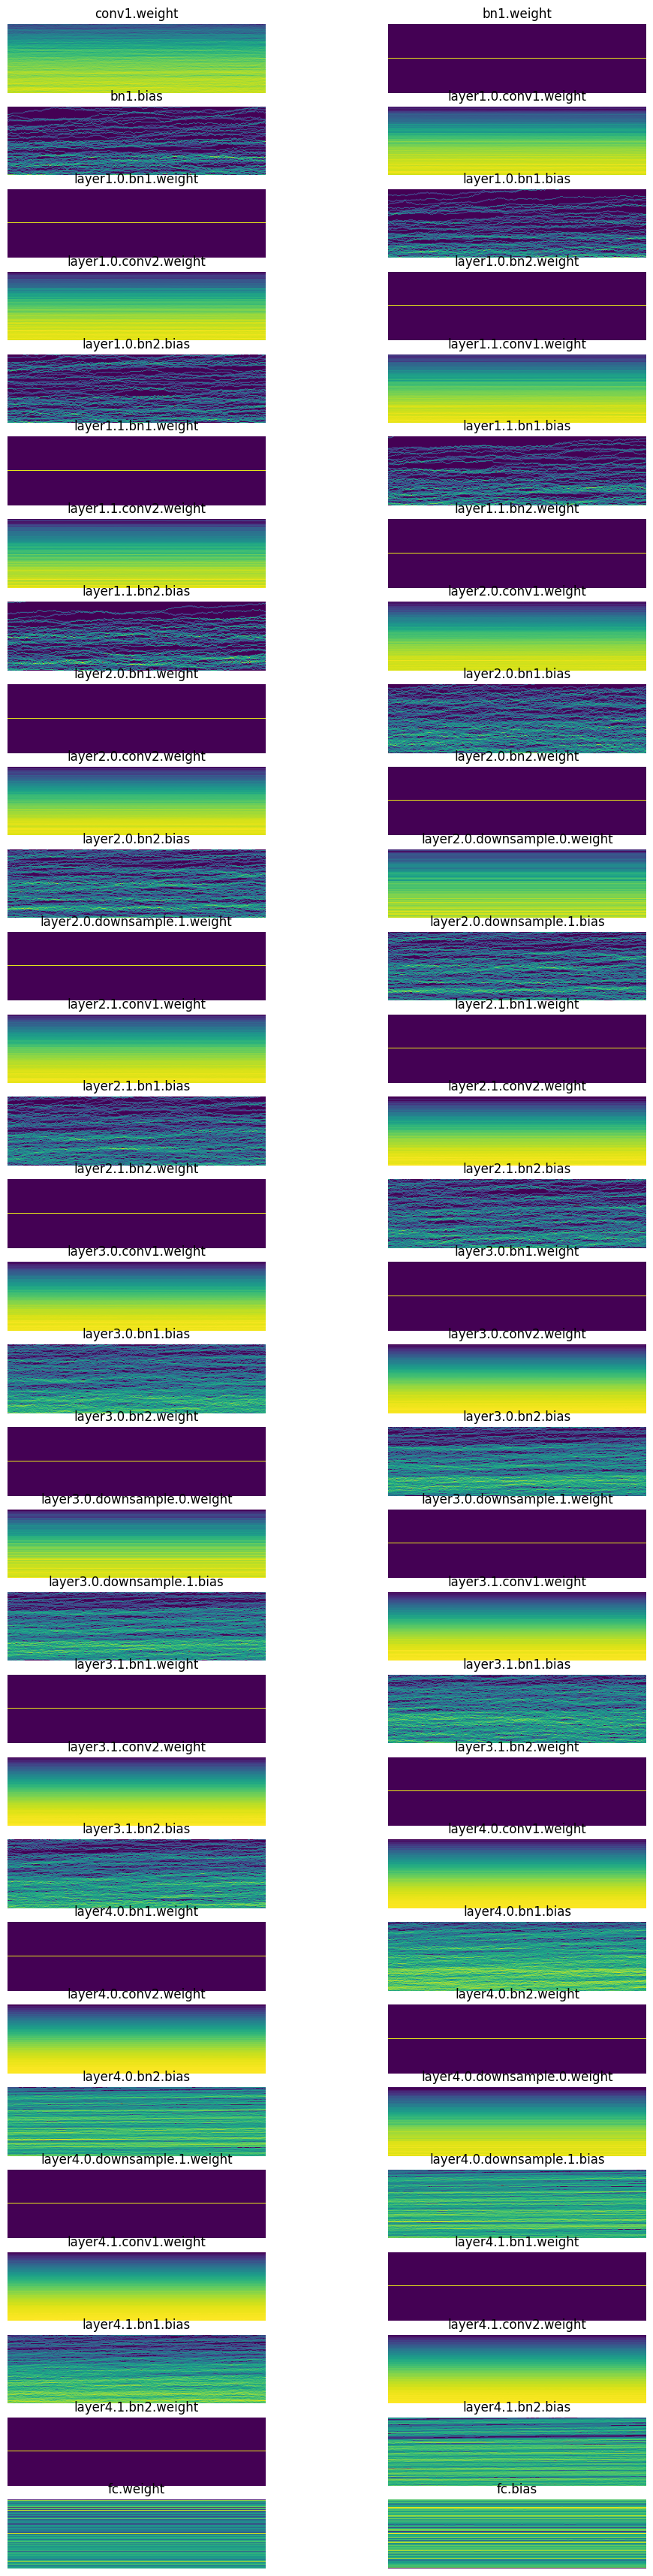

In [23]:
show_colorful_grid(learn.cbs[-1].log)

In [24]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[GradLogCallback])
    learn.fit(6)

hm, these FP32 gradients mostly look the same, though we are not getting a horizontal line for the batchnorm weights.

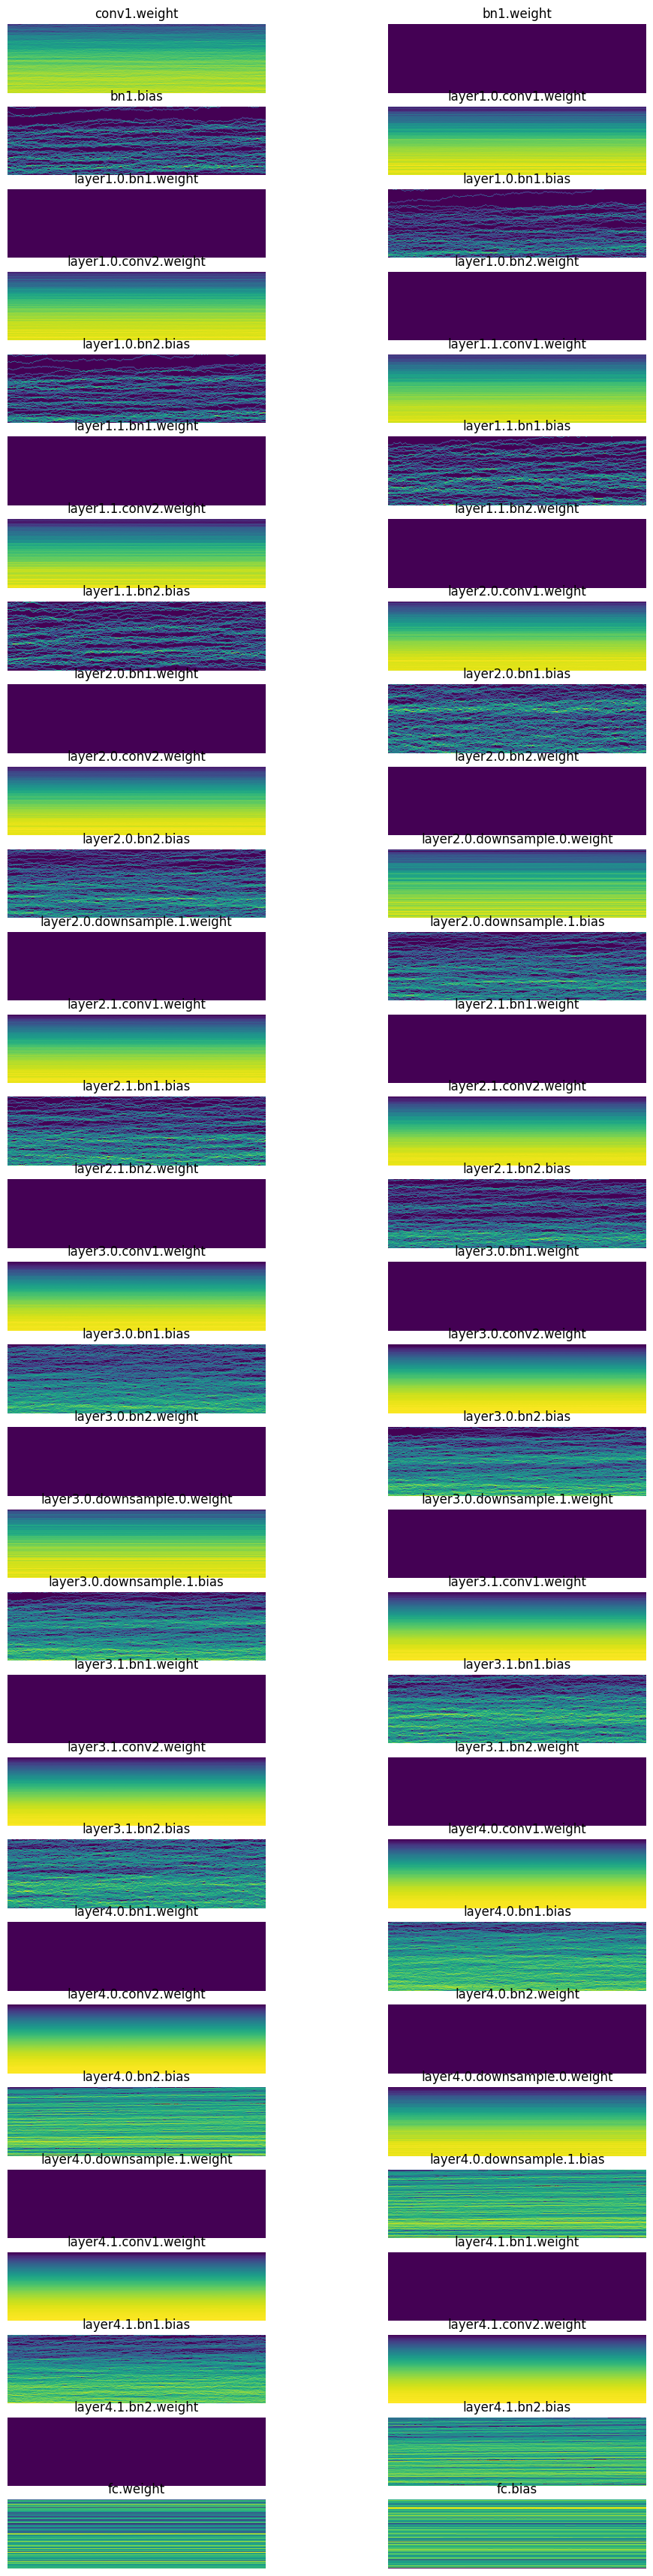

In [25]:
show_colorful_grid(learn.cbs[-1].log)

In [26]:
fp32_log=learn.grad_log.log

One thing to note is that the minimum positive value for fp16 is a not as small as fp32. 

In [27]:
torch.tensor(2**-24,dtype=torch.half),torch.tensor(2**-149)

(tensor(5.9605e-08, dtype=torch.float16), tensor(1.4013e-45))

hm, the batchnorm weight gradients standard deviations are **ZERO** for fp16! 

In [28]:
[[k,fp16_log[k][0].item(),fp32_log[k][0].item()] for k in fp16_log if 'bn' in k]

[['bn1.weight', 0.0, 0.0060293180868029594],
 ['bn1.bias', 0.004148084670305252, 0.003580566728487611],
 ['layer1.0.bn1.weight', 0.0, 0.005399828776717186],
 ['layer1.0.bn1.bias', 0.004158522468060255, 0.0034905048087239265],
 ['layer1.0.bn2.weight', 0.0, 0.004458598792552948],
 ['layer1.0.bn2.bias', 0.0027511364314705133, 0.0024442975409328938],
 ['layer1.1.bn1.weight', 0.0, 0.0039586215279996395],
 ['layer1.1.bn1.bias', 0.002898486563935876, 0.002269925782456994],
 ['layer1.1.bn2.weight', 0.0, 0.0035925875417888165],
 ['layer1.1.bn2.bias', 0.001713279401883483, 0.0014464608393609524],
 ['layer2.0.bn1.weight', 0.0, 0.003240257501602173],
 ['layer2.0.bn1.bias', 0.0017084497958421707, 0.0014696172438561916],
 ['layer2.0.bn2.weight', 0.0, 0.002757459646090865],
 ['layer2.0.bn2.bias', 0.0018845133017748594, 0.0017825027462095022],
 ['layer2.1.bn1.weight', 0.0, 0.0026580658741295338],
 ['layer2.1.bn1.bias', 0.0015702887903898954, 0.0015195324085652828],
 ['layer2.1.bn2.weight', 0.0, 0.0021

### Letting Batchnorm stay in FP32

We create a function here that just allows us to apply a funtion to both our module, and one of its parameters. 

In [29]:
def apply_p(f,m):
    for module in m.children():
        apply_p(f,module)
        for n,p in module.named_parameters(recurse=False):
            f(module,n)

Here we allow BatchNorm weights to stay in fp32.  

In [30]:
class fp16Callback(Callback):
    def before_fit(self):
        def f(m,n):
            getattr(m,n).data=getattr(m,n).data.float() if isinstance(m,nn.BatchNorm2d) else getattr(m,n).data.half()
        apply_p(f,self.learn.model)
    def before_batch(self):
        self.learn.xb=(self.xb[0].half(),)
    def after_pred(self):
        #loss should be calculated in fp32 as well
        self.learn.pred=self.learn.pred.float()

In [31]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback,GradLogCallback])
    learn.fit(6)

hmm, we have slightly better results, but nothing too close to our fp32 model. 

In [32]:
fp16_bn_log=learn.grad_log.log

Though, we have gotten the bn weights to have gradients! 

In [33]:
[[k,fp16_log[k][0].item(),fp16_bn_log[k][0].item(),fp32_log[k][0].item()] for k in fp16_log if 'bn' in k]

[['bn1.weight', 0.0, 0.006746089085936546, 0.0060293180868029594],
 ['bn1.bias',
  0.004148084670305252,
  0.003786720335483551,
  0.003580566728487611],
 ['layer1.0.bn1.weight', 0.0, 0.005284080747514963, 0.005399828776717186],
 ['layer1.0.bn1.bias',
  0.004158522468060255,
  0.003640677547082305,
  0.0034905048087239265],
 ['layer1.0.bn2.weight', 0.0, 0.005027716979384422, 0.004458598792552948],
 ['layer1.0.bn2.bias',
  0.0027511364314705133,
  0.0025208923034369946,
  0.0024442975409328938],
 ['layer1.1.bn1.weight', 0.0, 0.00424396526068449, 0.0039586215279996395],
 ['layer1.1.bn1.bias',
  0.002898486563935876,
  0.002260061912238598,
  0.002269925782456994],
 ['layer1.1.bn2.weight', 0.0, 0.004007537383586168, 0.0035925875417888165],
 ['layer1.1.bn2.bias',
  0.001713279401883483,
  0.0016484896186739206,
  0.0014464608393609524],
 ['layer2.0.bn1.weight', 0.0, 0.0031620513182133436, 0.003240257501602173],
 ['layer2.0.bn1.bias',
  0.0017084497958421707,
  0.0016835747519508004,
  0.00

### Looking at the gradients

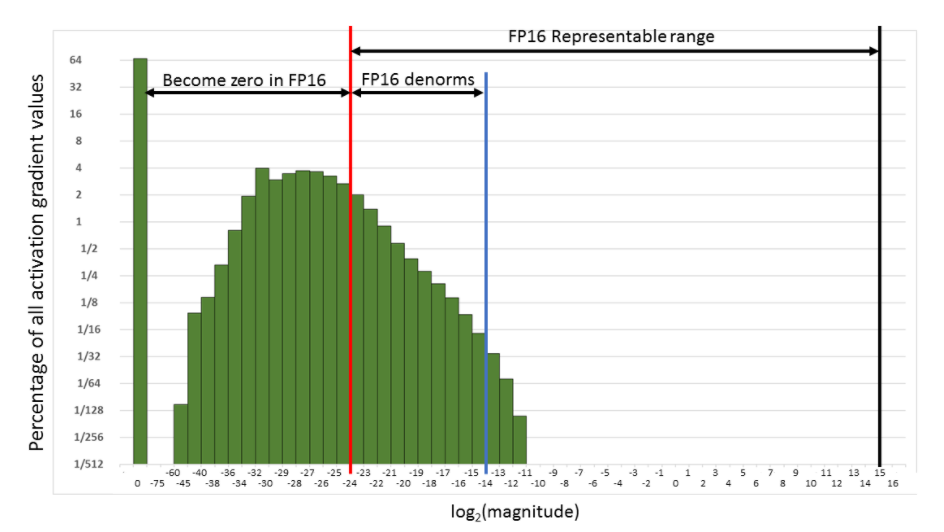

Image taken from here: https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html

Above we can see that some of the gradients will go to zero in fp16. This will happen more as the model trains and the gradients get smaller throughout training. 

Here we are create seperate FP16 parameters for our model, while our optimizer uses the fp32 weights. We scale up the loss by **128** before our backwards pass, to increase the size of the gradients. We then descale it back **128** when converting back to fp32 for our optimizer step. 

In [34]:
@patch
def before_fit(self:fp16Callback):
    self.opt_params= [p for p in self.model.parameters()]
    def f(m,n):
        value=getattr(m,n).data.float() if isinstance(m,nn.BatchNorm2d) else getattr(m,n).data.half()
        setattr(m,n,nn.Parameter(value))
    apply_p(f,self.learn.model)
@patch
def before_backward(self:fp16Callback):
    self.learn.loss_grad=128*self.learn.loss_grad
@patch
def after_backward(self:fp16Callback):
    for mp,op in zip(self.learn.model.parameters(),self.opt_params):
        op.grad=mp.grad.to(dtype=torch.float32)/128
@patch
def after_step(self:fp16Callback):
    for mp,op in zip(self.learn.model.parameters(),self.opt_params):
        mp.data= op.data.to(dtype=torch.float16) if(op.grad.dtype!=mp.grad.dtype) else op.data.clone()
    self.learn.model.zero_grad()

In [35]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback,GradLogCallback])
    learn.fit(6)

And, now we have results comparable to fp32! 

### Can we do this in a non-manual way? 

Well we start at the maximum possible multiple as the `loss_scale`. We multiply our gradients by this value. Yes, this value is definitely going to be too big so we need a strategy for decreasing the value now. 

In [ ]:
@patch
def before_fit(self:fp16Callback):
    self.loss_scale=2.**24
    self.count=0
    self.opt_params= [p for p in self.model.parameters()]
    def f(m,n):
        value=getattr(m,n).data.float() if isinstance(m,nn.BatchNorm2d) else getattr(m,n).data.half()
        setattr(m,n,nn.Parameter(value))
    apply_p(f,self.learn.model)
@patch
def before_backward(self:fp16Callback):
    self.learn.loss_grad=self.loss_scale*self.learn.loss_grad

This gets really messy, but we decrease by half if we overflow. We then skip the current batch and go to the next batch. This does mean we will hit a lot of skipped batches in the beginning of training. As our model trains, our gradients will probably get smaller, so we will want to increase our `loss_scale`. For this example we just test every 500 batches to see if we should increase our `loss_scale`.

In [36]:
@patch
def after_backward(self:fp16Callback):
    for mp in self.learn.model.parameters():
        if mp.grad is not None and test_overflow(mp.grad.data):
            self.learn.model.zero_grad()
            self.loss_scale/=2
            raise CancelBatchException()
    for mp,op in zip(self.learn.model.parameters(),self.opt_params):
        op.grad=mp.grad.to(dtype=torch.float32)/self.loss_scale
    self.count += 1
    if self.count == 500:
        self.count = 0
        self.loss_scale *= 2

In [37]:
with less_random():
    dls=create_dls()
    learn=Learner(dls,resnet18(),opt_func=SGD,cbs=[fp16Callback,GradLogCallback])
    learn.fit(6)

You can look more into all of this by checking out `NonNativeMixedPrecision`. 